<a href="https://colab.research.google.com/github/alibouch/TensorFlow_FSA_21-22/blob/main/Atelier_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atelier 7 : Traitement des séries avec des RNN

In [ ]:

import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path

np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Les RNN basiques

## Génération du Dataset

 
**Nous utilisons la fonction `generate_time_series()` pour générer des séries chronologiques univariées :**

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

**Elle crée autant de séries chronologiques que demandé (à l’aide de l’argument `batch_size`), chacune de longueur `n_steps`. Chaque série comprend une seule valeur par étape temporelle (toutes les séries sont univariées). La fonction retourne un tableau NumPy de forme [`taille du lot, étapes temporelles, 1`], où chaque série est la somme de deux courbes sinusoïdales d’amplitude fixe, mais de fréquences et de phases aléatoires, auxquelles est ajouté un peu de bruit.**

**Créons à présent un jeu d’entraînement, un jeu de validation et un jeu de test à l’aide de cette fonction:**

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

**`X_train` contient 7 000 séries chronologiques (autrement dit, sa forme est `[7000, 50, 1]`), tandis que `X_valid` en contient 2000 (de la 7 000<sup>ème</sup> série chronologique à la 8999<sup>ème</sup> ) et* X_test*, 1 000 (de la 9000<sup>ème</sup>  à la 9999<sup>ème</sup> ). Puisque nous souhaitons prévoir une seule valeur pour chaque série, les cibles sont des vecteurs colonnes (par exemple, la forme de `y_train` est `[7 000, 1]`)**

In [ ]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

**La figure suivante montre trois séries chronologiques univariées, chacune longue de 50 étapes temporelles, avec pour objectif de prévoir la valeur de l’étape temporelle suivante (représentée par le point bleu) dans chaque cas.**

Saving figure time_series_plot


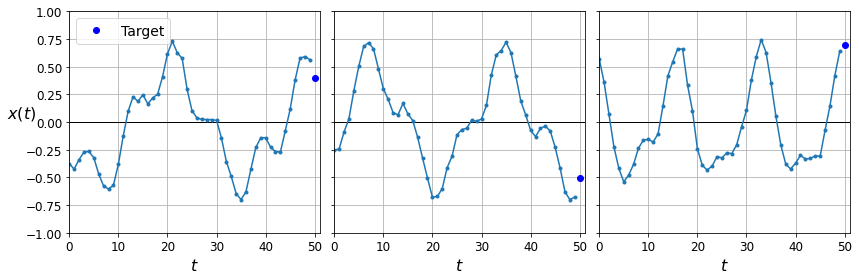

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

## Indicateurs de référence

**Avant d’utiliser des RNN, il vaut mieux disposer de quelques indicateurs de référence afin d’être certains que le fonctionnement de notre modèle est meilleur et non pire que les modèles de base. Par exemple, la méthode la plus simple consiste à prédire la dernière valeur dans chaque série. Il s’agit d’une prévision simpliste, mais elle est parfois difficile à réaliser correctement. Dans le cas suivant, nous obtenons une erreur quadratique moyenne d’environ `0,020`:**

In [ ]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

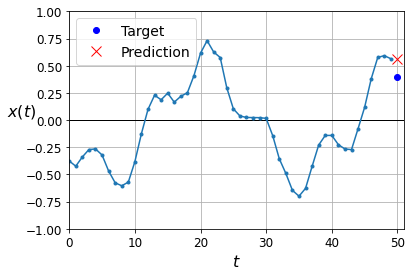

In [ ]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

**Une autre approche simple se fonde sur un réseau intégralement connecté.
Puisqu’il attend pour chaque entrée une liste plate de caractéristiques, nous devons ajouter une couche `Flatten`. Un simple modèle de régression linéaire permettra d’obtenir une prédiction qui soit une combinaison linéaire des valeurs des séries temporelles:**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

**Si nous compilons ce modèle en utilisant la perte MSE et l’optimiseur Adam par défaut, l’appliquons au jeu d’entraînement pendant vingt époques et l’évaluons sur le jeu de validation, nous obtenons une MSE d’environ 0,004. Le résultat est bien meilleur que celui de l’approche simpliste :**

In [ ]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 4ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0062

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0042


0.004168086219578981

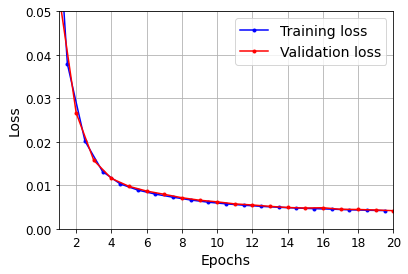

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

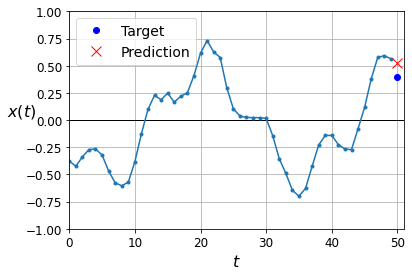

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Implémenter un RNN simple

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

**1. En utilisant la couche `SimpleRNN`, créez un simple  RNN qui comprend une seule couche, avec un seul neurone `(n'oubliez pas qu'il est inutile de préciser la longueur des séries d’entrée,contrairement au modèle précédent, car un réseau de neurones récurrents est capable de traiter un nombre quelconque d’étapes temporelles)` :**

In [ ]:
model = keras.models.Sequential([
                                                  )
])

**Nous compilons, préparons et évaluons ce modèle (comme précédemment, l’entraînement se fait sur vingt époques avec Adam) :**

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 16s 68ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 14s 65ms/step - loss: 0.011

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0109


0.010881561785936356

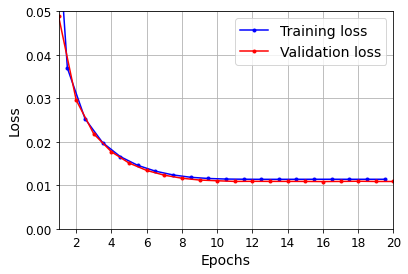

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

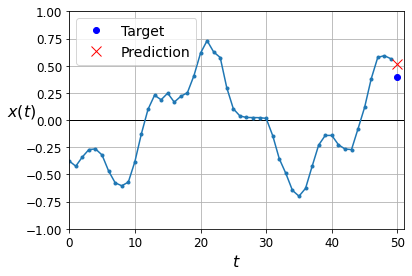

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

**Vous constaterez que la MSE de ce modèle arrive à 0,014 seulement. C’est mieux que l’approche simpliste, mais nous n’avons pas battu le modèle linéaire simple. Apparemment, notre RNN était trop simple pour arriver à de bonnes performances. Voyons ce que cela donne en ajoutant d’autres couches récurrentes.**

#  RNN profonds

**1. Créez un RNN profond en emplilant 2 couches `SimpleRNN` de 20 neurones chacune, suivies d'une autre couche `SimpleRNN` avec un seul neurone. N'oubliez pas d'indiquer aux deux premières couches retourner une sortie par étape temporelle :**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                                                 ,
                                                       ,
             
])

In [ ]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 51s 221ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 47s 217ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 48s 217ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 48s 220ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 47s 217ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 48s 219ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 48s 221ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 48s 219ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 48s 218ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 48s 220ms/step - l

**vous constaterez que la MSE arrive à 0,003. C'est mieux que le modèle linéaire.**

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 21ms/step - loss: 0.0029


0.002910560928285122

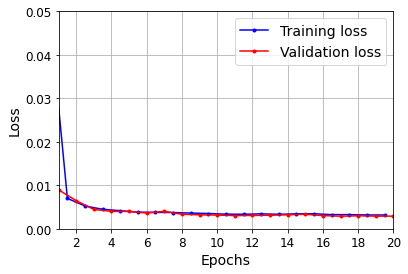

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

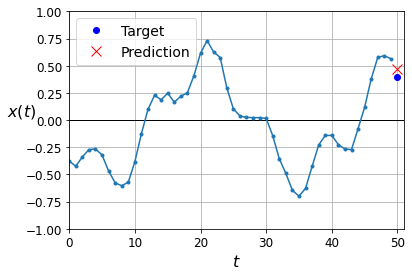

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

**Dans le modèle précédent, vous noterez que la dernière couche n’est pas idéale : puisque nous voulons prévoir une série chronologique univariée, et donc avoir une seule valeur de sortie par étape temporelle, elle ne doit avoir qu’une seule unité. Mais, cette seule unité signifie que l’état caché est un seul nombre. C’est vraiment peu et probablement pas très utile ; il est fort probable que le RNR utilisera principalement les états cachés des autres couches récurrentes pour reporter d’une étape temporelle à l’autre toutes les informations dont il a besoin et qu’il n’utilisera pas l’état caché de la dernière couche.**

**Par ailleurs, puisqu’une couche `SimpleRNN` se sert par défaut de la fonction d’activation `tanh`, les valeurs prédites doivent se situer dans la plage −1 à 1. Et si vous souhaitez utiliser une autre fonction d’activation? Pour ces deux raisons, il peut être plus intéressant de remplacer la couche de sortie par une couche `Dense`: son exécution sera légèrement plus rapide, la précision sera quasi identique, et nous pourrons choisir la fonction d’activation de sortie qui nous convient.**

**2. Effectuez ce changement et n’oubliez d'ajuster la deuxième couche réccurente afin q'elle retournent uniquement la sortie finale :**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                                                          ,
                                ,
    
])

In [ ]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 32s 141ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 31s 140ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 30s 138ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 31s 143ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 30s 138ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 30s 138ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 30s 136ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 31s 139ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 31s 140ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 30s 137ms/step - l

**Vous constaterez que le modèle converge plus rapidement et que ses performances sont aussi bonnes. Mais, en bonus, vous pouvez modifier la fonction d’activation de sortie si nécessaire.**

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 14ms/step - loss: 0.0026


0.0026236234698444605

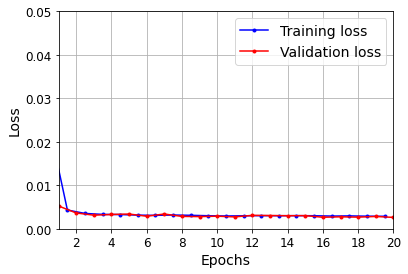

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

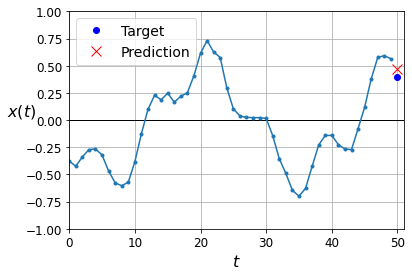

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# Prévision de plusieurs étapes temporelles à l’avance

**Jusqu’à présent, nous avons uniquement prédit la valeur à l’étape temporelle suivante, mais nous aurions pu tout aussi bien prédire la valeur plusieurs étapes à l’avance en modifiant les cibles de façon appropriée (par exemple, pour effectuer la prédiction dix étapes à l’avance, il suffit de changer les cibles de sorte qu’elles aient la valeur pour dix étapes à l’avance plutôt qu’une seule). Mais comment pouvons-nous prédire les dix prochaines valeurs?**

**La première solution consiste à utiliser le modèle déjà entraîné, à lui faire prédire la valeur suivante, à ajouter cette valeur aux entrées (faire comme si cette valeur prédite s’était déjà produite), et à utiliser à nouveau le modèle pour prédire la valeur d’après, et ainsi de suite :**

**1. Complétez le code suivant pour qu'il réalise cette solution :** 

In [ ]:
np.random.seed(43) 

series = generate_time_series(1, n_steps + 10)
X_new, Y_new =                 ,  
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[ ,              ])[ ,    ,  ]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [ ]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


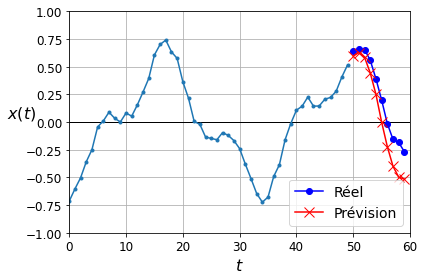

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Réel")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Prévision", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

**La deuxième solution est d’entraîner un RNN pour qu’il prédise les dix prochaines valeurs en une fois. Nous pouvons toujours utiliser un modèle série-vers-vecteur (sequence-to-vector), mais il produira dix valeurs à la place d’une seule. Nous devons commencer par modifier les cibles pour qu’elles soient des vecteurs contenant les dix prochaines valeurs:**



In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

**2. Ajustez le modèle précédent afin qu’il prédise les dix prochaines
valeurs en une fois :**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                                                          ,
                               ,
    
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 32s 137ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 30s 137ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 30s 135ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 30s 137ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 30s 137ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 30s 138ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 30s 136ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 30s 138ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 30s 136ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 30s 136ms/step - l

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

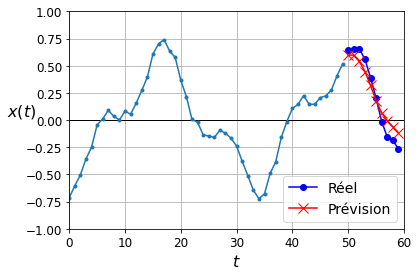

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

**Nous pouvons faire mieux encore : au lieu d’entraîner le modèle à prévoir les dix valeurs suivantes uniquement lors de la toute dernière étape temporelle, nous pouvons l’entraîner pour la prévision des dix valeurs suivantes à chaque étape temporelle. Autrement dit, nous pouvons convertir ce RNN série-vers-vecteur (sequence-to-vector) en un RNN série-vers-série (sequence-to-sequence). Grâce à cette technique, la perte contiendra un terme pour la sortie du RNN non pas uniquement lors de la dernière étape temporelle mais lors de chaque étape temporelle.
Autrement dit, le nombre de gradients d’erreur circulant dans le modèle sera plus élevé et ce ne sera pas uniquement en suivant le temps; ils découleront également de la sortie de chaque étape temporelle. L’entraînement en sera ainsi stabilisé et accéléré.**

**Pour être plus clair, à l’étape temporelle 0, le modèle produira un vecteur contenant les prévisions pour les étapes 1 à 10, puis, à l’étape temporelle 1, le modèle prévoira les étapes temporelles 2 à 11, et ainsi de suite. Par conséquent, chaque cible doit être une série de même longueur que celle d’entrée, en contenant un vecteur à dix dimensions à chaque étape. Préparons ces séries cibles:**

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

**Pour transformer le modèle en une version série-vers-série, nous devons préciser `return_sequences=True` dans toutes les couches récurrentes (même la dernière) et nous devons appliquer la couche de sortie Dense à chaque étape temporelle. Dans ce but, Keras fournit la couche `TimeDistributed`: elle enveloppe n’importe quelle couche (par exemple, une couche `Dense`) et l’applique à chaque étape temporelle de sa série d’entrée. Elle procède de façon efficace, en modifiant les entrées de sorte que chaque étape temporelle soit traitée comme une instance distincte (autrement dit, elle change la forme des entrées de `[taille de lot, étapes temporelles, dimensions d’entrée]` à `[taille de lot × étapes temporelles, dimensions d’entrée]`; dans notre exemple, le nombre de dimensions d’entrée est égal à 20, car la couche `SimpleRNN` précédente comprend vingt unités), puis elle exécute la couche Dense, et, pour finir, remet les sorties sous forme de séries (autrement dit, elle change la forme des sorties de `[taille de lot × étapes temporelles, dimensions d’entrée]` à `[taille de lot, étapes temporelles, dimensions d’entrée]`; dans notre exemple, le nombre de dimensions de sortie est égal à 10, car la couche Dense comprend dix unités).**

**3. Transformez le modèle précédent en un modèle série-vers-série (sequence-to-sequence) :**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                                                       ,
                                                       ,
    
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 32s 139ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 30s 137ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0352 - val_last_time_step_mse: 0.0244
Epoch 3/20
219/219 [==============================] - 30s 139ms/step - loss: 0.0327 - last_time_step_mse: 0.0215 - val_loss: 0.0314 - val_last_time_step_mse: 0.0208
Epoch 4/20
219/219 [==============================] - 30s 138ms/step - loss: 0.0295 - last_time_step_mse: 0.0182 - val_loss: 0.0275 - val_last_time_step_mse: 0.0159
Epoch 5/20
219/219 [==============================] - 30s 139ms/step - loss: 0.0274 - last_time_step_mse: 0.0155 - val_loss: 0.0258 - val_last_time_step_mse: 0.0135
Epoch 6/20
219/219 [==============================] - 30s 137ms/step - loss: 0.0251 - last_time_step_mse: 0.0125 - val_loss: 0.0219 - val_last_time_step_mse: 0.0084
Epoch 7/20

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

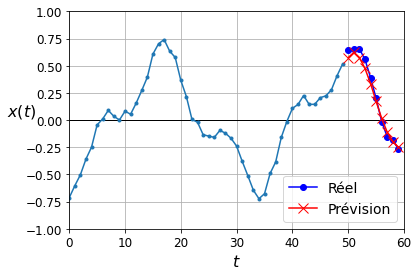

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# La normalisation par couches pour les RNN profonds



**Pour entraîner un RNN sur des séries longues, nous devons l’exécuter sur de nombreuses étapes temporelles, faisant du RNN déroulé un réseau très profond. À l’instar de n’importe quel réseau de neurones profond, il peut être confronté au problème
d’instabilité des gradients : l’entraînement peut durer indéfiniment ou devenir instable. Plusieurs solutions pour alléger le problème d’instabilité des gradients dans les réseaux profonds telles que la normalisation par lots peuvent être employées avec les RNN. Or, la normalisation par lots ne sera pas aussi efficace dans les RNN que dans les réseaux non bouclés profonds. En réalité, vous ne pouvez pas l’employer
entre les étapes temporelles, mais uniquement entre les couches récurrentes**

**Par ailleurs, il existe une autre forme de normalisation mieux adaptée aux RNN: *la normalisation par couches*. Elle ressemble énormément à la normalisation par lots, mais elle se fait non plus suivant les lots mais suivant les caractéristiques (features). L’intérêt est que le calcul des
statistiques requises peut se faire à la volée, à chaque étape temporelle, indépendamment pour chaque instance. En conséquence, elle se comporte de la même manière pendant l’entraînement et les tests (contrairement à la normalisation par lots), et
elle n’a pas besoin des moyennes mobiles exponentielles pour estimer les statistiques de caractéristiques sur toutes les instances du jeu d’entraînement. À l’instar de la normalisation par lots, la normalisation par couche apprend un paramètre de mise à l’échelle et un paramètre de décalage pour chaque entrée. Dans un RNN, elle se place généralement juste après la combinaison linéaire des entrées et des états cachés.**

**Utilisons `tf.keras` pour mettre en place une normalisation par couche à l’intérieure d’une cellule de mémoire simple. Pour cela, nous devons définir une cellule de mémoire personnalisée. Elle est comparable à une couche normale, excepté que sa
méthode `call()` attend deux arguments: les entrées `inputs` de l’étape temporelle courante et les états cachés `states` de l’étape temporelle précédente. Notez que l’argument `states` est une liste contenant un ou plusieurs tenseurs. Dans le cas d’une cellule de RNN simple, il contient un seul tenseur égal aux sorties de l’étape temporelle précédente, mais d’autres cellules pourraient avoir des tenseurs à plusieurs états. Une cellule doit également avoir les attributs `state_size` et `output_size`. Dans un RNN simple, tous deux sont simplement égaux au nombre d’unités.** 

**1.Complétez le code suivant qui implémente une cellule de mémoire personnalisée qui se comporte comme
un `SimpleRNNCell`, hormis la normalisation par couche appliquée à chaque étape temporelle :**

In [ ]:
from tensorflow.keras.layers import LayerNormalization

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = 
                                                          
        self.layer_norm = 
        self.activation = 
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = 
        norm_outputs = 
        return norm_outputs, [norm_outputs]

**2. Pour profiter de cette cellule personnalisée, créer une couche `keras.layers.RNN` en lui passant une instance de la cellule :**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                                                           ,                   
                                                              ,
    
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 75s 318ms/step - loss: 0.1668 - last_time_step_mse: 0.1624 - val_loss: 0.0738 - val_last_time_step_mse: 0.0686
Epoch 2/20
219/219 [==============================] - 69s 315ms/step - loss: 0.0639 - last_time_step_mse: 0.0567 - val_loss: 0.0569 - val_last_time_step_mse: 0.0498
Epoch 3/20
219/219 [==============================] - 70s 322ms/step - loss: 0.0538 - last_time_step_mse: 0.0462 - val_loss: 0.0504 - val_last_time_step_mse: 0.0428
Epoch 4/20
219/219 [==============================] - 68s 312ms/step - loss: 0.0472 - last_time_step_mse: 0.0386 - val_loss: 0.0444 - val_last_time_step_mse: 0.0358
Epoch 5/20
219/219 [==============================] - 67s 304ms/step - loss: 0.0416 - last_time_step_mse: 0.0316 - val_loss: 0.0390 - val_last_time_step_mse: 0.0284
Epoch 6/20
219/219 [==============================] - 67s 305ms/step - loss: 0.0384 - last_time_step_mse: 0.0274 - val_loss: 0.0367 - val_last_time_step_mse: 0.0256
Epoch 7/20